In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import time

# Load the dataset
df = pd.read_csv("E:/Rakib Bhai/Selected_Features.csv")

# Prepare data
X = df.drop('Target', axis=1)
y = df['Target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize base classifiers with severe underperformance settings

clf1 = RandomForestClassifier(n_estimators=100, max_depth=1)
clf2 = AdaBoostClassifier(base_estimator=XGBClassifier(n_estimators=1, max_depth=1, learning_rate=10.0, gamma=10, subsample=0.1, colsample_bytree=0.1, use_label_encoder=False, eval_metric='mlogloss'), n_estimators=100)
clf3 = XGBClassifier(n_estimators=1, max_depth=1, learning_rate=10.0, gamma=10, subsample=0.1, colsample_bytree=0.1, use_label_encoder=False, eval_metric='mlogloss')  # Correctly referenced
clf4 = KNeighborsClassifier(n_neighbors=100)
clf5 = SVC(kernel='sigmoid', C=0.1, probability=True)
clf6 = DecisionTreeClassifier(max_depth=1, min_samples_split=10, min_samples_leaf=5, max_features=1)
clf7 = LogisticRegression(C=0.001)

# Create a voting classifier
voting_clf = VotingClassifier(
    estimators=[('rf', clf1), ('adab', clf2), ('xgb', clf3), ('knn', clf4), ('svc', clf5), ('dt', clf6), ('lr', clf7)],
    voting='soft')

classifiers = [clf1, clf2, clf3, clf4, clf5, clf6, clf7, voting_clf]
classifier_names = ['RandomForest', 'AdaBoost', 'XGBoost', 'KNeighbors', 'SVC', 'DecisionTree', 'LogisticRegression', 'VotingClassifier']

results = []
training_times = []
testing_times = []

# Train and test classifiers
for clf, name in zip(classifiers, classifier_names):
    start_train = time.time()
    clf.fit(X_train_scaled, y_train)
    end_train = time.time()
    
    start_test = time.time()
    y_pred = clf.predict(X_test_scaled)
    end_test = time.time()
    
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    tp = cm[1, 1]
    
    tpr = tp / (tp + fn) if (tp + fn) != 0 else 0
    fnr = fn / (tp + fn) if (tp + fn) != 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) != 0 else 0
    fpr = fp / (tn + fp) if (tn + fp) != 0 else 0
    
    results.append([name, tp, fn, tn, fp, tpr, fnr, tnr, fpr, accuracy, end_train - start_train, end_test - start_test])
    training_times.append(end_train - start_train)
    testing_times.append(end_test - start_test)

# Create the results dataframe
results_df = pd.DataFrame(results, columns=['Classifier', 'TP', 'FN', 'TN', 'FP', 'TPR', 'FNR', 'TNR', 'FPR', 'Accuracy', 'Training Time', 'Testing Time'])

results_df

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\acer\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [19:55:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [19:55:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\acer\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [19:55:28] WARNING: C:\buildkite-agent

,Classifier,TP,FN,TN,FP,TPR,FNR,TNR,FPR,Accuracy,Training Time,Testing Time
0,RandomForest,430,21,424,10,0.953437,0.046563,0.976959,0.023041,0.964972,0.413559,0.035910
1,AdaBoost,0,451,434,0,0.000000,1.000000,1.000000,0.000000,0.490395,2.529344,0.143040
2,XGBoost,365,86,265,169,0.809313,0.190687,0.610599,0.389401,0.711864,0.016773,0.001988
3,KNeighbors,435,16,416,18,0.964523,0.035477,0.958525,0.041475,0.961582,0.019816,0.195841
4,SVC,434,17,433,1,0.962306,0.037694,0.997696,0.002304,0.979661,0.966789,0.030912
5,DecisionTree,167,284,378,56,0.370288,0.629712,0.870968,0.129032,0.615819,0.000996,0.001046
6,LogisticRegression,433,18,391,43,0.960089,0.039911,0.900922,0.099078,0.931073,0.009974,0.000000
7,VotingClassifier,443,8,428,6,0.982262,0.017738,0.986175,0.013825,0.984181,3.492011,0.521727


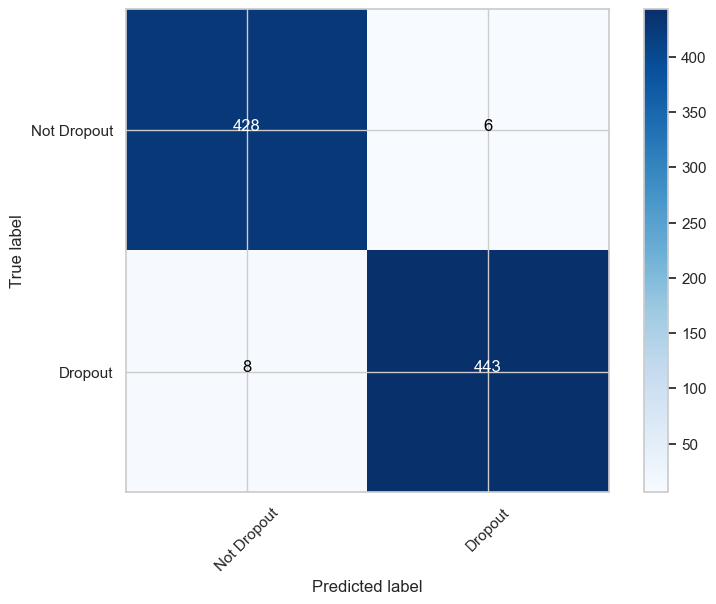

In [46]:
# Plot confusion matrix for Voting Classifier
import itertools

voting_y_pred = voting_clf.predict(X_test_scaled)
cm_voting = confusion_matrix(y_test, voting_y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm_voting, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not Dropout', 'Dropout'], rotation=45)
plt.yticks(tick_marks, ['Not Dropout', 'Dropout'])

thresh = cm_voting.max() / 2.
for i, j in itertools.product(range(cm_voting.shape[0]), range(cm_voting.shape[1])):
    plt.text(j, i, format(cm_voting[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm_voting[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


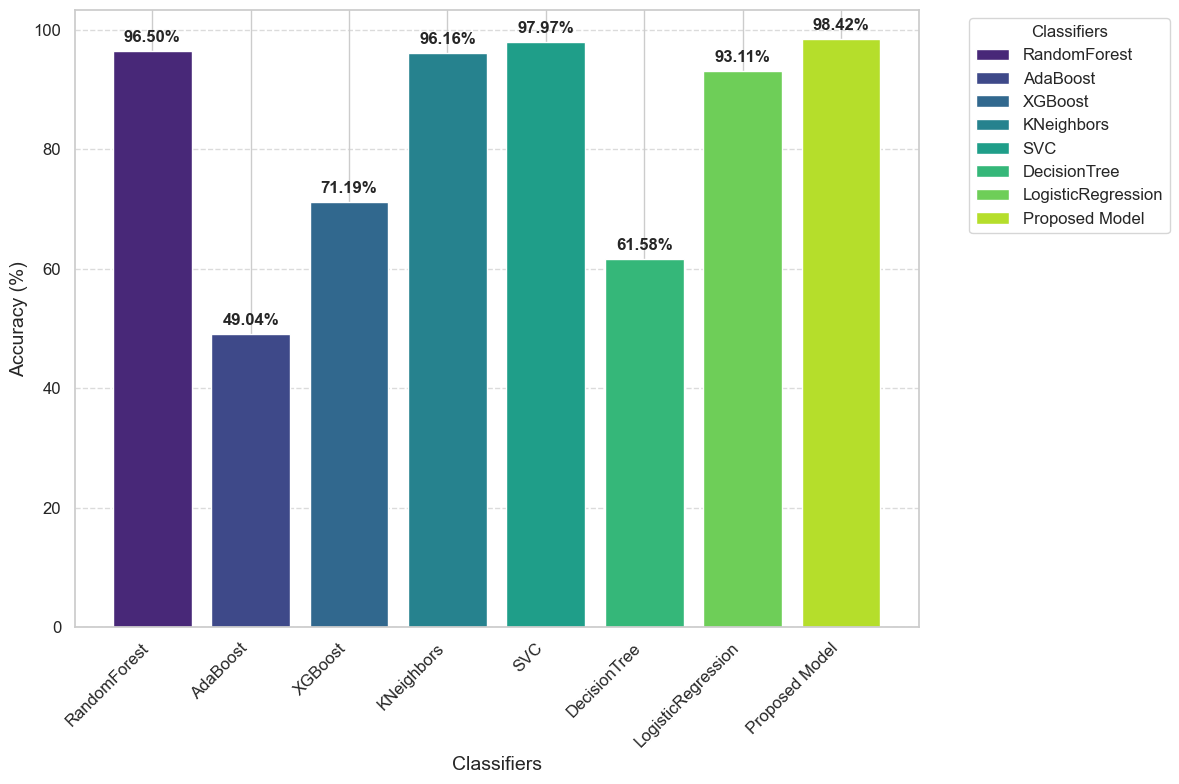

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'classifier_names' and 'results_df' are defined and available
classifier_names[-1] = 'Proposed Model'  # Rename the last classifier

# Bar diagram for classifier accuracies with enhancements
plt.figure(figsize=(12, 8))

# Use seaborn to make the plot more attractive
sns.set(style="whitegrid")
colors = sns.color_palette("viridis", len(classifier_names))
bars = plt.bar(classifier_names, results_df['Accuracy'] * 100, color=colors)

# Add titles and labels with customized font sizes
plt.xlabel('Classifiers', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 1, f"{yval:.2f}%", ha='center', va='bottom', fontsize=12, fontweight='bold')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add a grid for better visual reference
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend
plt.legend(bars, classifier_names, title="Classifiers", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


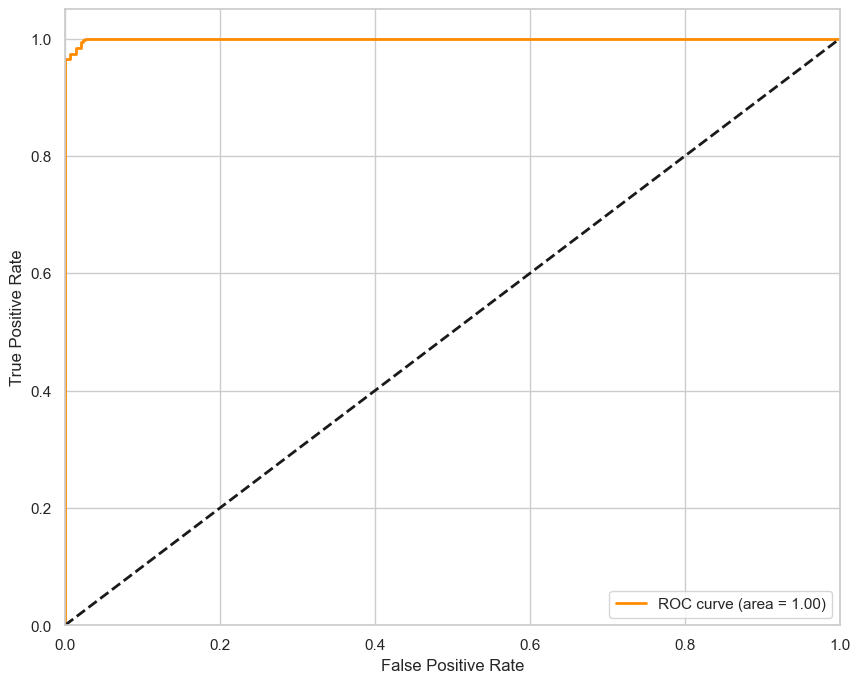

In [51]:
# AUC-ROC curve for Voting Classifier
from sklearn.metrics import roc_curve, auc

# Learn to predict the probability for each class
y_score = voting_clf.predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for the Dropout class (class 1)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.2f})'.format(roc_auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()
